# Mini Project 1: Deep Q-learning for Epdicemic Mitigation

**Amin Asadi Sarijalou**: **347814**

**Ilker Gül**: **353296**

## Introduction

### Description

### Environment Setup

1. Install conda if you don't have it (see [the conda documentation here](https://conda.io/projects/conda/en/latest/user-guide/install/index.html) to learn how to do so)
2. Create a dedicated environment and install the packages in the environment by running the following commands:
```
conda create -n epi
conda activate epi
conda install pytorch torchvision torchaudio -c pytorch
conda install numpy networkx matplotlib pyyaml jupyter tqdm pandas
pip install gym
pip install ipykernel

### Importing necessary libraries

In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline


from tqdm import tqdm

explain what you have done

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


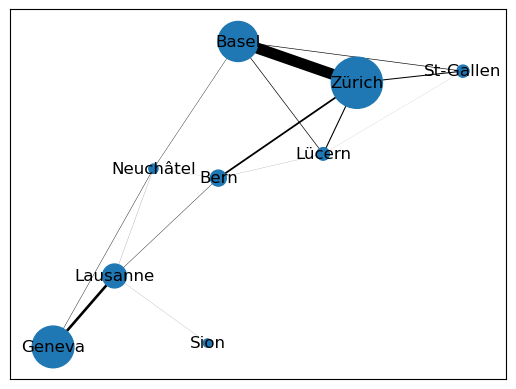

In [2]:
### Define the dynamics of the environment
### can be reused by all problems because env.reset() will reset the dynamics as well
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
print(dyn.cities)
dyn.draw_map()

## Question 1

#### Actions

- 'confinement': Represents imposing confinement or lockdown measures. False indicates it is not being imposed.
- 'isolation': Represents enforcing isolation measures. False indicates it is not being enforced.
- 'hospital': Represents admitting patients to hospitals. False indicates this action is not being taken.
- 'vaccinate': Represents administering vaccinations. False indicates no vaccinations are being given.

#### helper functions

In [3]:
from matplotlib.ticker import MultipleLocator

# parameters for action_preprocessor
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

# parameter for observation_preprocessor
SCALE = 100

# Parse the logs
def parse_logs(log: Log, dyn: ModelDynamics):
    total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    
    return total, cities, actions

# Plot 1: s[w], e[w], i[w], r[w], d[w] over time
def plot_all_totals(total: dict, axis: plt.Axes):
    # plt.figure()
    for y in total.values():
        axis.plot(y)
    axis.legend(total.keys())
    axis.set_xlabel('Weeks')
    axis.set_ylabel('Number of people in each state')
    axis.set_title('Total Population Over Time')

# Plot 2: i[w], d[w] over time
def plot_infected_dead(total: dict, axis: plt.Axes):
    # plt.figure()
    for state in ['infected', 'dead']:
        axis.plot(total[state])
    axis.legend(['infected', 'dead'])
    axis.set_xlabel('Weeks')
    axis.set_ylabel('Number of people')
    axis.set_title('Infected and Dead Population Over Time')

# Plot 3: i[w], d[w] over time, one subplot per city
def plot_infected_dead_per_city(dyn: ModelDynamics, cities: dict, axis: plt.Axes):
    # n_cities = len(dyn.cities)
    # fig, axes = plt.subplots(3, 3, figsize=(12, n_cities))
    # axes = axes.flatten()
    # for i, city in enumerate(dyn.cities):
    #     for state in ['infected', 'dead']:
    #         axes[i].plot(cities[city][state])
    #     axes[i].legend(['infected', 'dead'])
    #     axes[i].set_title(f'City {city}')
    #     axes[i].set_xlabel('Weeks')
    #     axes[i].set_ylabel('Number of people')
    # fig.suptitle('Infected and Dead Population Over Time per City')

    [ax.plot(cities[c]['infected']) for c, ax in axis.items()]
    [ax.plot(cities[c]['dead']) for c, ax in axis.items()]
    [ax.set_ylabel(c) for c, ax in axis.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in axis.items()]
    axis['Zürich'].set_xlabel('time (in weeks)')
    axis['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    ## similar to tutorial
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    out = torch.Tensor(np.stack((infected, dead))).unsqueeze(0)
    
    ## recommended by the project description to pass the observation tensor through (.)^0.25 to avoid very small values in the tensor
    return out**(0.25)

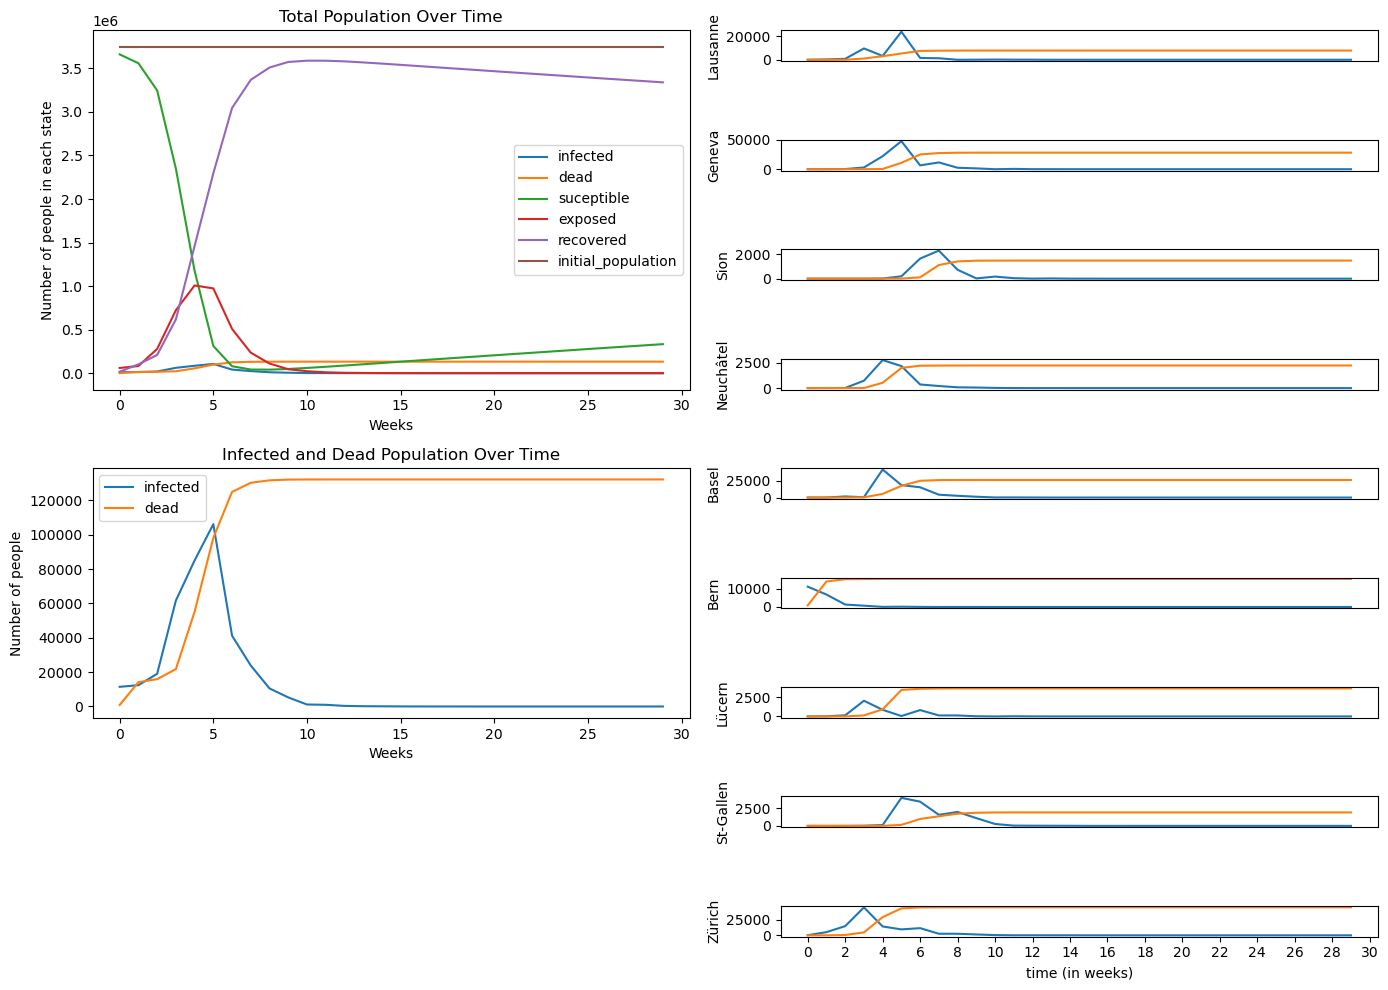

In [4]:
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            action_preprocessor=action_preprocessor,
            )

NULL_ACTION = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

# Run the simulation
seed = 42
log = []
finished = False
obs, info = env.reset(seed)
for t in range(30):
    obs, R, finished, info = env.step(NULL_ACTION)
    log.append(info)
    if finished:
        break

# parse the logs
total, cities, actions = parse_logs(log, dyn)

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
# ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}


## 1.a
#1.a.1
plot_all_totals(total, ax_leftstate)

#1.a.2
plot_infected_dead(total, ax_leftobs)

#1.a.3
plot_infected_dead_per_city(dyn, cities, ax_right)

plt.tight_layout()
plt.show()


In [5]:
for state in total.keys():
    print(state)
    print(total[state])

infected
[ 11449  12407  19044  61656  85035 106165  41221  23820  10512   5282
   1150    987    340    162    103     48     21      8      5      0
      0      0      0      0      0      0      0      0      0      0]
dead
[   890  14158  15929  21747  55169  98202 124957 130248 131686 132089
 132164 132178 132181 132181 132181 132181 132181 132181 132181 132181
 132181 132181 132181 132181 132181 132181 132181 132181 132181 132181]
suceptible
[3661019 3559452 3247377 2349507 1175370  311809   79706   41831   40650
   48221   60196   73356   87609  102273  116925  131811  146783  161594
  176183  190675  205287  219865  233996  248440  262657  277241  291411
  305299  319258  333396]
exposed
[  59764   82029  278438  722950 1007560  973527  508025  235215  110750
   45221   22493   10050    4311    2083     983     477     222     105
      49      23      11       6       2       0       0       0       0
       0       0       0]
recovered
[  16700  101287  208948  617237 146156

#### **DISCUSSION**

**INFECTED**:

**DEAD**:

**SUSCEPTIBLE**:The susceptible population comprises individuals who have not contracted the infection but could become infected upon exposure to the virus. As the outbreak advances, the susceptible population typically declines. This happens because more people are exposed to the virus and then transition to other states, such as infected, recovered, or dead.

Analyzing the provided data, you can observe the following trend:

- At the beginning of the epidemic, the number of susceptible individuals is high (3,733,920).
- As the epidemic progresses, more people become exposed and infected, so the susceptible population decreases.
- The susceptible population reaches its lowest point (54,583) when the infected population is at its peak (119,039). This suggests that a large portion of the susceptible population has either been infected, recovered, or died.
- After the epidemic peak, the susceptible population starts to increase again as the number of new infections decreases. This can be attributed to individuals recovering or dying, resulting in fewer infected people to spread the virus to susceptible individuals.


**EXPOSED**:

**RECOVERED**:


## Question 2

#### Part A

Implement Pr. Russo’s Policy as a python class (we recommend that you subclass the Agent abstract class provided with the project files, and as is demonstrated in the tutorial notebook). Run the epidemic simulation for one episode using Pr. Russo’s Policy to pick actions and produce four plots:

#### Helper functions

In [6]:

def plot_does_confine(actions: np.array, axis: plt.Axes):
    axis.imshow(np.expand_dims(actions, 0).astype(np.uint8), aspect='auto')    
    axis.set_title('Actions')
    axis.set_xticks(np.arange(0, len(actions), 2))
    axis.set_yticks([0])
    axis.set_yticklabels(['confinement'])
    axis.set_xlabel('time (in weeks)')


In [7]:
class RussosAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Pr. Russos' agent: Confines the whole country if the number of infected people
        is above 20,000 if not already done
        """
        self.week_counter = 0
        self.in_confinement = False
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the routine for optimizing the model
        pass
    
    def reset(self,):
        # This should be called when the environment is reset
        self.week_counter = 0
        self.in_confinement = False
    
    ## do_explore is auxiliary here and for the reuse evaluate_agnet function
    def act(self, obs, do_explore=True):
        # this takes an observation and returns an action
        if self.in_confinement and self.week_counter < 4:
            self.week_counter += 1
            return 1
        elif self.in_confinement and self.week_counter >= 4:
            self.week_counter = 0
            self.in_confinement = False

        num_infected = obs.total.infected[-1]

        if num_infected > 20_000:
            self.in_confinement = True
            return 1
        else:
            return 0

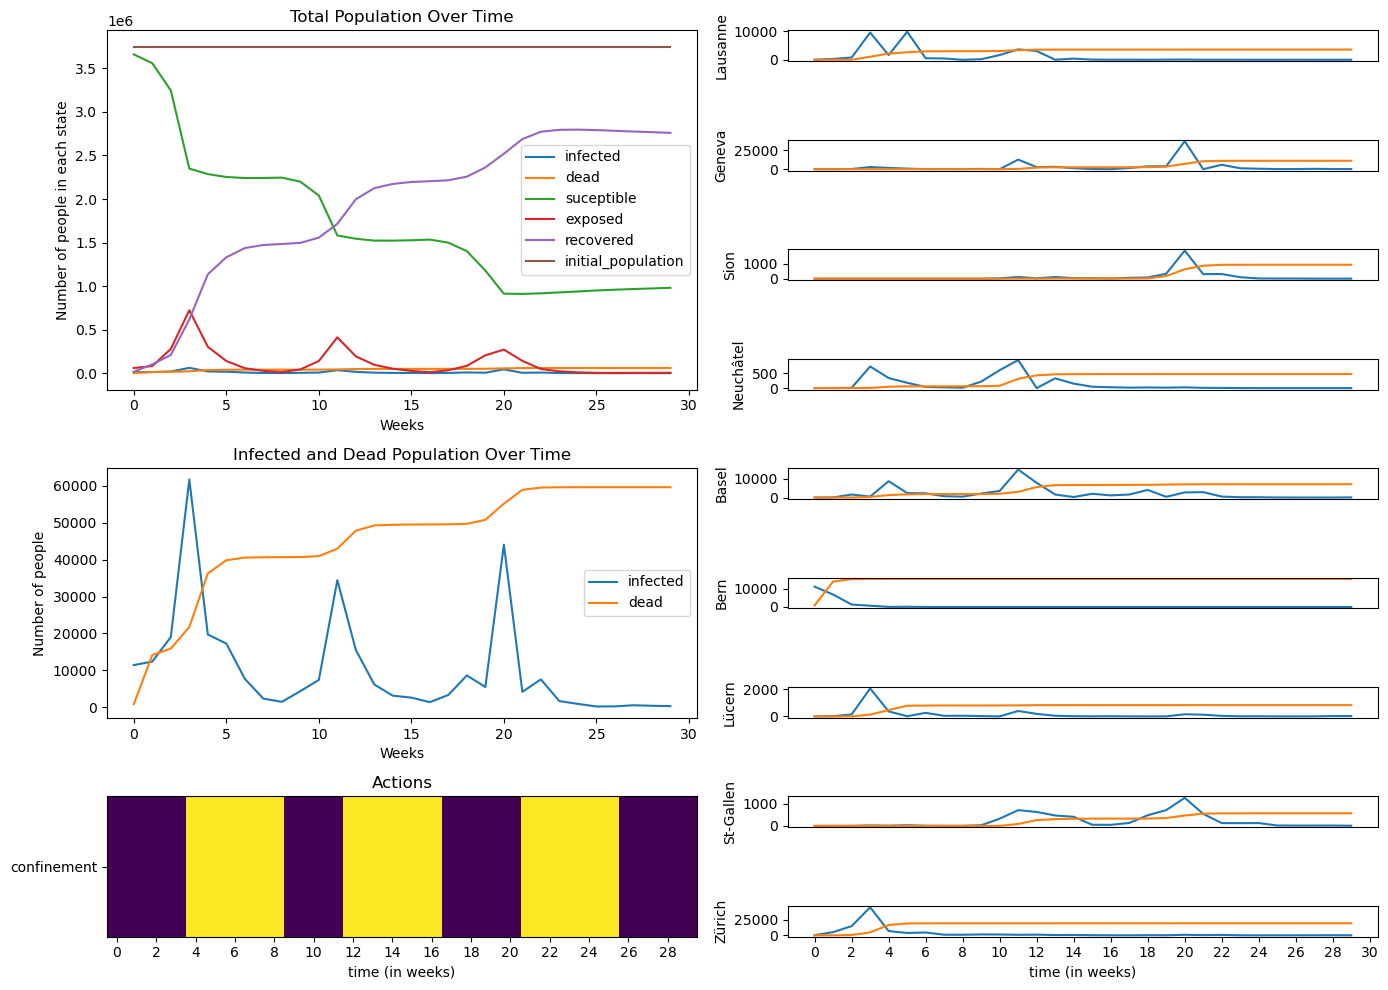

In [8]:
agent = RussosAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed)
agent.reset()
agent.epsilon = 0
for _ in range(30):
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    
total, cities, actions = parse_logs(log, dyn)

##2.a
fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

#2.a.1
plot_all_totals(total, ax_leftstate)

#2.a.2
plot_infected_dead(total, ax_leftobs)

#2.a.3
plot_infected_dead_per_city(dyn, cities, ax_right)

#2.a.4
plot_does_confine(actions['confinement'], ax_leftactions)

plt.tight_layout()
plt.show()

In [9]:
def evaluate_agent(agent: Agent, env: Env, n_episodes: int, do_explore: bool = True):
    num_total_deaths = []
    cumulative_reward = []
    num_total_confined_days = []


    for trial_i in tqdm(range(n_episodes)):
        log = []
        finished = False
        agent.reset()
        agent.epsilon = 0

        cum_R = 0
        total_deaths = 0
        num_confined_weeks = 0

        seed = torch.randint(0, 1000, (1,)).item()
        obs, info = env.reset(seed)
        
        for _ in range(30):
            if finished:
                break
            action = agent.act(obs, do_explore)
            obs, R, finished, info = env.step(action)
            log.append(info)
            cum_R += R
            total_deaths += info.total.dead
            # print(action)
            if action == 1:
                num_confined_weeks += 1

        cumulative_reward.append(cum_R.item())
        num_total_deaths.append(total_deaths)
        num_total_confined_days.append(num_confined_weeks * 7)
    
    return cumulative_reward, num_total_deaths, num_total_confined_days

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


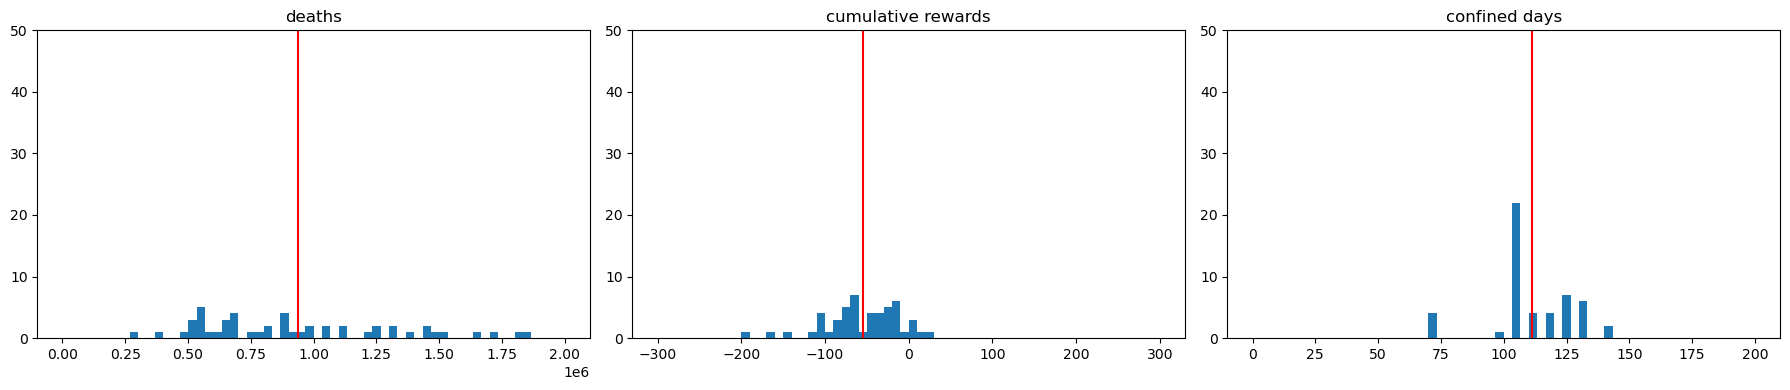

Average death number: 937784.0
Average cumulative reward: -54.80609775066376
Average number of confined days: 111.44


In [10]:
torch.manual_seed(seed)
n_episodes = 50

rewards, deaths, conf_days = evaluate_agent(agent, env, n_episodes, do_explore=True)

fig, ax = plt.subplots(1, 3, figsize=(18,4))
def hist_avg(ax, data, title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,2_000_000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data, bins=60, range=x_range)

hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()


print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(conf_days)}')

## Question 3

In [11]:
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=None,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, info = env.reset(seed)

In [12]:
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        random_indices = torch.randint(0, len(self.memory), (batch_size,))
        return [self.memory[i] for i in random_indices]

    def __len__(self):
        return len(self.memory)

In [13]:
import torch.optim as optim
import torch.nn.functional as F

import math

from tqdm import tqdm

In [14]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.hidden_layer_1 = nn.Linear(n_observations, 64)
        self.hidden_layer_2 = nn.Linear(64, 32)
        self.hidden_layer_3 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        x = self.output_layer(x)

        return x

In [25]:
class DQNAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                eps_start:float = 0.7,
                eps_end:float=0.7,
                num_episodes:int=500,
                ):
        """
        DQN Agent
        """
        # BATCH_SIZE is the number of transitions sampled from the replay buffer
        # GAMMA is the discount factor as mentioned in the previous section
        # EPS_START is the starting value of epsilon
        # EPS_END is the final value of epsilon
        # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
        # TAU is the update rate of the target network
        # LR is the learning rate of the ``AdamW`` optimizer
        self.BATCH_SIZE = 128
        self.GAMMA = 0.9
        self.EPS_START = eps_start
        self.EPS_END = eps_end
        self.TAU = 5e-3
        self.LR = 5e-3
        self.num_episodes = num_episodes

        # Get number of actions from gym action space
        n_actions = 2
        # Get the number of state observations
        obs, info = env.reset(seed)
        n_observations = obs.flatten().shape[0]

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(n_observations, n_actions).to(self.device)
        self.target_net = DQN(n_observations, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.memory = ReplayMemory(10000)

        self.steps_done = 0

    def load_model(self, savepath="./models/"):
        # This is where one would define the routine for loading a pre-trained model
        self.target_net.load_state_dict(torch.load(savepath + "target_net.pt"))
        self.policy_net.load_state_dict(torch.load(savepath + "policy_net.pt"))
        
    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(agent.policy_net.state_dict(), savepath + "policy_net.pt")
        torch.save(agent.target_net.state_dict(), savepath + "target_net.pt")
        

    def train(self, save_path):
        worst_cumulative_reward = float('-inf')
        training_trace = []
        evaluation_trace = []

        for trial_i in tqdm(range(self.num_episodes)):
            # Initialize the environment and get it's state
            obs, info = env.reset(torch.randint(0, 1000, (1,)).item())
            # obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)

            cum_R = 0

            for t in range(30):
                if obs == None:
                    break
                action = self.act(obs)

                ## I changed this part from the original code (it was expecting a truncate flag an oring that with the terminate flag)
                next_obs, reward, terminated, info  = env.step(action.item())
                cum_R += reward
                reward = torch.tensor([reward], device=self.device)
                # done = terminated

                # if terminated:
                #     next_obs = None
                # else:
                #     # next_obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
                #     next_obs = obs

                # Store the transition in memory
                # print('selected_action: ', action)
                self.memory.push(obs, action, next_obs, reward)

                # Move to the next state
                obs = next_obs
            
                training_trace.append(cum_R.item())

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

            if (trial_i % 50 == 0) or (trial_i == self.num_episodes-1):
                # Evaluate the agent
                cumulative_reward, num_total_deaths, num_total_confined_days = evaluate_agent(agent, env, 20, do_explore=False)
                evaluation_trace.append(np.mean(np.mean(cumulative_reward)))
        
                # if done:
                    # episode_durations.append(t + 1)
                    # plot_durations()
                    # break

                # print('Complete')
                # plot_durations(show_result=True)
                # plt.ioff()
                # plt.show()

            if np.mean(cumulative_reward) > worst_cumulative_reward:
                worst_cumulative_reward = np.mean(cumulative_reward)
                self.save_model(save_path)

        return training_trace, evaluation_trace


    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        policy_net_input = state_batch.flatten(start_dim=1)
        policy_net_output = self.policy_net(policy_net_input)
        state_action_values = policy_net_output.gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
        with torch.no_grad():
            target_net_input = non_final_next_states.flatten(start_dim=1)
            target_net_output = self.target_net(target_net_input)
            next_state_values[non_final_mask] = target_net_output.max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return 0
    
    def reset(self):
        #reset the inner state of the agent
        self.steps_done = 0

    
    def act(self, obs, do_explore=True):
        # this takes an observation and returns an action
        sample = torch.rand(1)
        # eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1. * self.steps_done / self.EPS_DECAY)
        eps_threshold = max(self.EPS_END,  self.EPS_START - self.steps_done / self.num_episodes)
        self.steps_done += 1

        if do_explore and sample <= eps_threshold:
            return torch.tensor([[env.action_space.sample()]], device=self.device, dtype=torch.long)
        else:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                dqn_input = obs.flatten()
                dqn_output = self.policy_net(dqn_input)
                selected_action = torch.tensor([[dqn_output.argmax()]])
                # print('selected action: ', selected_action)
                return selected_action

In [26]:
torch.manual_seed(seed)

agent = DQNAgent(env, eps_start=0.7, eps_end=0.7, num_episodes=500)

training_trace, evaluation_trace = agent.train(save_path="./models/eps_fixed/")

100%|██████████| 500/500 [10:21<00:00,  1.24s/it]


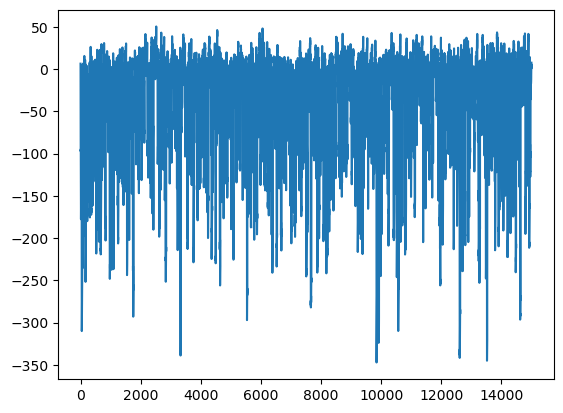

In [27]:
plt.plot(range(len(training_trace)), training_trace, label='training');

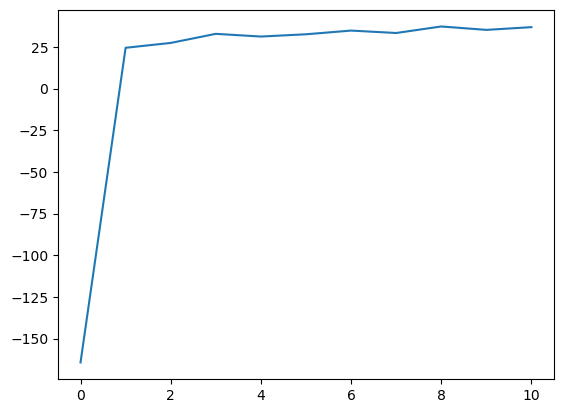

In [28]:
plt.plot(range(len(evaluation_trace)), evaluation_trace, label='evaluation');

100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


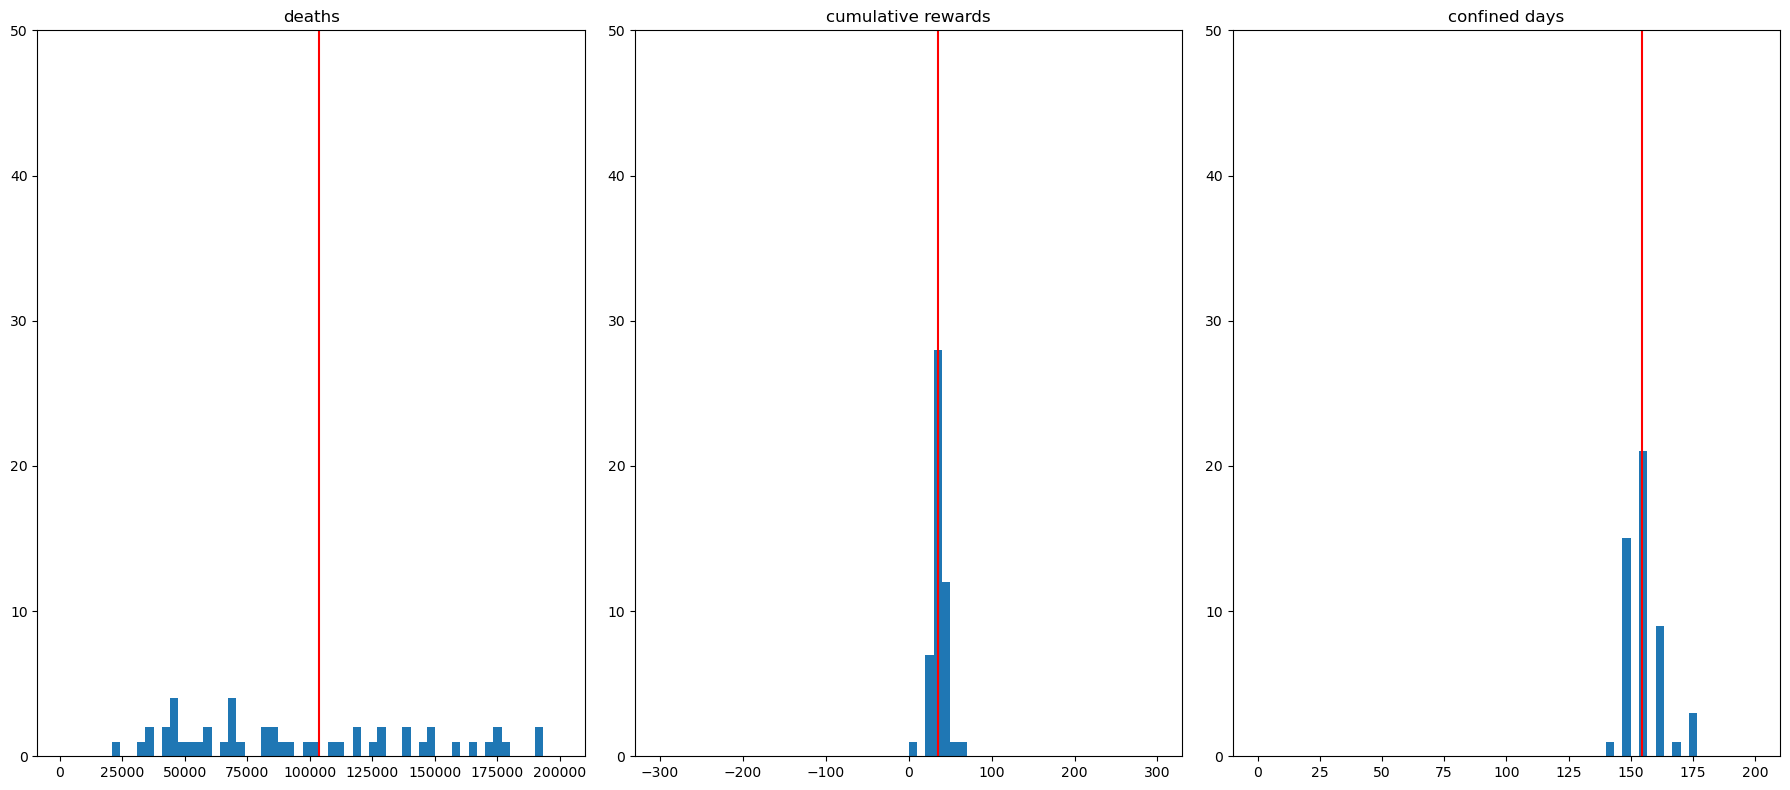

Average death number: 103692.34
Average cumulative reward: 35.84871025562286
Average number of confined days: 154.42


In [30]:
torch.manual_seed(seed)

agent = DQNAgent(env, eps_start=0.7, eps_end=0.7, num_episodes=500)

agent.load_model(savepath="./models/eps_fixed/")

rewards, deaths, conf_days = evaluate_agent(agent, env, 50, do_explore=False)

fig, ax = plt.subplots(1, 3, figsize=(18,8))
def hist_avg(ax, data, title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)

hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()


print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(conf_days)}')

In [16]:
torch.manual_seed(seed)

agent = DQNAgent(env, eps_start=0.9, eps_end=0.2, num_episodes=500)

training_trace, evaluation_trace = agent.train(save_path="./models/eps_decay/")

100%|██████████| 500/500 [10:17<00:00,  1.23s/it]


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


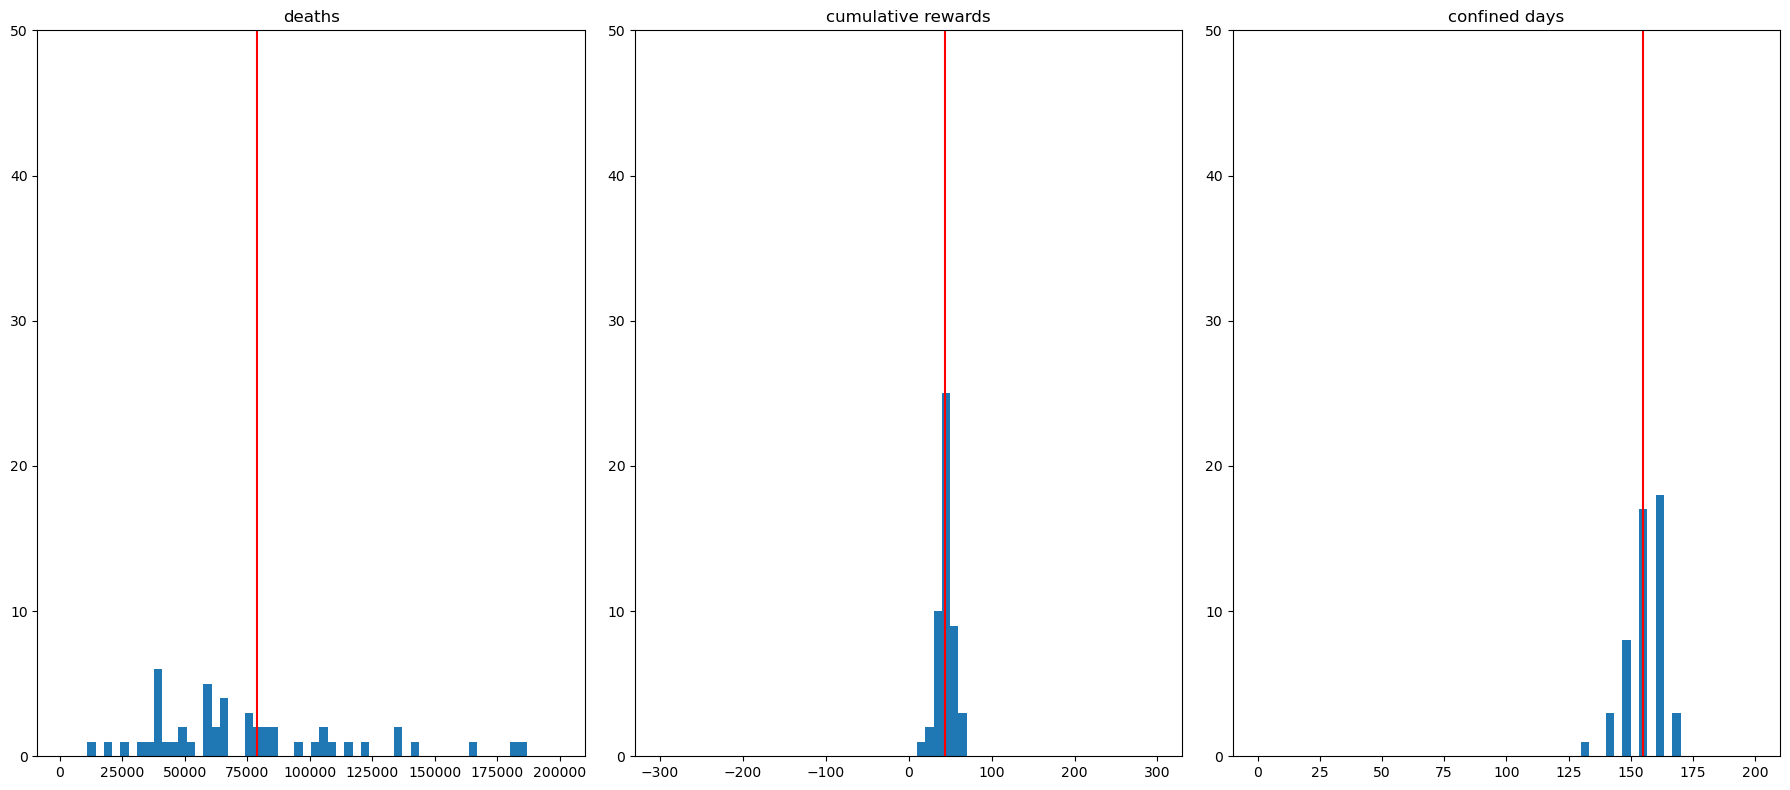

Average death number: 79016.5
Average cumulative reward: 43.93873586654663
Average number of confined days: 154.98


In [22]:
torch.manual_seed(seed)

agent = DQNAgent(env, eps_start=0.7, eps_end=0.7, num_episodes=500)

agent.load_model()

rewards, deaths, conf_days = evaluate_agent(agent, env, 50, do_explore=False)

fig, ax = plt.subplots(1, 3, figsize=(18,8))
def hist_avg(ax, data, title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)

hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()


print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(conf_days)}')